# BiLSTM с Word2Vec эмбеддингами для классификации AG News

Ноутбук реализует классификатор BiLSTM с предобученными Word2Vec эмбеддингами для датасета AG News.

**Цель**: сравнить влияние предобученных эмбеддингов на качество BiLSTM модели.

**Датасет**: AG News (train/val 90/10 сплит фиксированным сидом; test отдельно)

**Модель**: Word2Vec Embedding(300) → BiLSTM(hidden=128, num_layers=1, bidirectional) → masked max-pooling по времени → Dropout(0.3) → Linear(4)


## Шаг 1: Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gensim.downloader as api

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.2
CUDA available: True


## Шаг 2: Загрузка и разбиение датасета

Используем тот же сплит что и в предыдущих ноутбуках для справедливого сравнения.


In [2]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(f"\nDataset structure:")
print(dataset)
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nClasses: {class_names}")


Loading AG News dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Train set size: 120000
Test set size: 7600

After split:
Train: 108000
Val: 12000
Test: 7600

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']


## Шаг 3: Токенизация и словарь

Строим словарь из обучающих данных. Используем ту же токенизацию для согласованности.


In [3]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
PAD_IDX = 0
UNK_IDX = 1

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

print("Building vocabulary...")
word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

print(f"Total unique words: {len(word_counter)}")
print(f"Words with freq >= 2: {sum(1 for count in word_counter.values() if count >= 2)}")

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX}
vocab_size = 2

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words: {list(vocab.keys())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}


Building vocabulary...
Total unique words: 62617
Words with freq >= 2: 42450

Vocabulary size: 30000
Top 10 words: ['<pad>', '<unk>', 'the', 'to', 'a', 'of', 'in', 'and', 's', 'on']


## Шаг 4: Загрузка предобученных Word2Vec эмбеддингов

Загружаем предобученные Word2Vec эмбеддинги (например, word2vec-google-news-300) и создаём матрицу эмбеддингов для нашего словаря.


In [4]:
print("Loading Word2Vec embeddings...")
w2v_model = api.load("word2vec-google-news-300")
embed_dim = w2v_model.vector_size

print(f"Word2Vec embedding dimension: {embed_dim}")
print(f"Vocabulary size in Word2Vec: {len(w2v_model)}")

embedding_matrix = np.zeros((len(vocab), embed_dim))

found_words = 0
for word, idx in vocab.items():
    if word == PAD_TOKEN:
        continue
    elif word == UNK_TOKEN:
        embedding_matrix[idx] = np.random.normal(0, 0.1, embed_dim)
    elif word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
        found_words += 1
    else:
        embedding_matrix[idx] = np.random.normal(0, 0.1, embed_dim)

print(f"\nFound embeddings for {found_words} words out of {len(vocab)}")
print(f"Coverage: {found_words / len(vocab) * 100:.2f}%")

embedding_matrix = torch.FloatTensor(embedding_matrix)
print(f"Embedding matrix shape: {embedding_matrix.shape}")


Loading Word2Vec embeddings...
[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 5.0% 83.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 6.8% 112.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.5% 140.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.2% 169.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.9% 197.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.7% 211.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.4% 239.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.7% 277.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 18.4% 305.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.5% 341.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.2% 369.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.6% 409.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.2% 435.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 28.1% 467.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.6% 525.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.3% 587.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.9% 646.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.3% 686.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.5% 723.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.8% 744.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.3% 787.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.7% 842.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 54.2% 901.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.4% 953.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.1% 1016.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 64.9% 1078.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 66.6% 1106.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.2% 1134.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.2% 1167.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================================---------------] 71.9% 1195.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.9% 1228.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.2% 1284.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.8% 1343.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.5% 1405.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================================------] 88.3% 1468.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 92.0% 1529.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.2% 1582.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================================--] 97.3% 1618.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec embedding dimension: 300
Vocabulary size in Word2Vec: 3000000

Found embeddings for 23694 words out of 30000
Coverage: 78.98%
Embedding matrix shape: torch.Size([30000, 300])


## Шаг 5: Dataset класс с динамическим паддингом

Dataset класс возвращает последовательности без фиксированного паддинга. Паддинг до max в батче будет выполняться в collate_fn.


In [5]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = simple_tokenize(text)
        indices = [self.vocab.get(token, UNK_IDX) for token in tokens]
        
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    max_len = max(lengths)
    
    padded_texts = []
    masks = []
    for text in texts:
        pad_length = max_len - len(text)
        padded = torch.cat([text, torch.full((pad_length,), PAD_IDX, dtype=torch.long)])
        mask = torch.cat([torch.ones(len(text), dtype=torch.bool), torch.zeros(pad_length, dtype=torch.bool)])
        padded_texts.append(padded)
        masks.append(mask)
    
    return torch.stack(padded_texts), torch.stack(masks), torch.stack(labels)

max_len = 128
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample_text, sample_label = train_dataset[0]
print(f"\nSample:")
print(f"  Text length: {len(sample_text)}")
print(f"  Label: {sample_label.item()} ({class_names[sample_label.item()]})")


Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600

Sample:
  Text length: 53
  Label: 1 (Sports)


## Шаг 6: Модель BiLSTM с предобученными эмбеддингами

Архитектура:
- Embedding слой: $E \in \mathbb{R}^{|V| \times d}$ где $d=300$ (Word2Vec), с `padding_idx=0`, инициализирован предобученными векторами
- BiLSTM: $\text{LSTM}(d, h=128, \text{bidirectional=True})$ → выход $h_t \in \mathbb{R}^{256}$ (forward + backward)
- Masked max-pooling: $\text{MaxPool}(\{h_t : \text{mask}_t = 1\})$ по временной оси
- Dropout(0.3) → Linear(256, 4)


In [6]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=128, num_layers=1, num_classes=4, dropout=0.3, embedding_matrix=None, freeze_embeddings=False):
        super().__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings, padding_idx=PAD_IDX)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x, mask):
        x = self.embedding(x)
        
        lstm_out, _ = self.lstm(x)
        
        mask_expanded = mask.unsqueeze(-1).expand_as(lstm_out)
        lstm_out_masked = lstm_out.masked_fill(~mask_expanded, float('-inf'))
        
        pooled, _ = torch.max(lstm_out_masked, dim=1)
        
        x = self.dropout(pooled)
        x = self.fc(x)
        return x


## Шаг 7: Lightning модуль

PyTorch Lightning модуль с training/validation шагами, логированием train/val loss, val accuracy и val macro F1. Gradient clipping с clip_val=1.0.


In [7]:
class BiLSTMModule(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=128, num_layers=1, num_classes=4, dropout=0.3, lr=1e-3, embedding_matrix=None, freeze_embeddings=False):
        super().__init__()
        self.save_hyperparameters()
        self.model = BiLSTM(vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout, embedding_matrix, freeze_embeddings)
        self.lr = lr
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, mask):
        return self.model(x, mask)
    
    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## Шаг 8: DataLoaders

Создаём DataLoaders с batch_size=128 и collate_fn для динамического паддинга.


In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

sample_batch = next(iter(train_loader))
x, mask, y = sample_batch
print(f"\nSample batch:")
print(f"  Text shape: {x.shape}")
print(f"  Mask shape: {mask.shape}")
print(f"  Labels shape: {y.shape}")


Train batches: 844
Val batches: 94
Test batches: 60

Sample batch:
  Text shape: torch.Size([128, 73])
  Mask shape: torch.Size([128, 73])
  Labels shape: torch.Size([128])


## Шаг 9: Обучение

Обучаем 3 эпохи с Adam оптимизатором (lr=1e-3), gradient_clip_val=1.0, seed=42. Эмбеддинги можно заморозить (freeze_embeddings=True) или дообучить (False). Отслеживаем время эпохи.


In [9]:
vocab_size = len(vocab)
freeze_embeddings = False

model = BiLSTMModule(
    vocab_size=vocab_size, 
    embed_dim=embed_dim, 
    hidden_dim=128, 
    num_layers=1, 
    num_classes=4, 
    dropout=0.3, 
    lr=1e-3,
    embedding_matrix=embedding_matrix,
    freeze_embeddings=freeze_embeddings
)

trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
    gradient_clip_val=1.0
)

print("Starting training...")
print(f"Freeze embeddings: {freeze_embeddings}")
start_time = time.time()
trainer.fit(model, train_loader, val_loader)
total_time = time.time() - start_time

bilstm_w2v_epoch_time = total_time / 3

print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {bilstm_w2v_epoch_time:.2f} seconds")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting training...
Freeze embeddings: False



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | BiLSTM             | 9.4 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | val_f1    | MulticlassF1Score  | 0      | train
4 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
9.4 M     Trainable params
0         Non-trainable params
9.4 M     Total params
37.765    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.



Training completed in 92.18 seconds
Average time per epoch: 30.73 seconds


## Шаг 10: Оценка на тесте

Оцениваем на test наборе: accuracy и macro F1 score.


In [10]:
test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, mask, y = batch
        logits = model(x, mask)
        preds = torch.argmax(logits, dim=1)
        
        test_acc(logits, y)
        test_f1(logits, y)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

bilstm_w2v_test_acc = test_acc.compute().item()
bilstm_w2v_test_f1 = test_f1.compute().item()

print(f"Test Accuracy: {bilstm_w2v_test_acc:.4f}")
print(f"Test Macro F1: {bilstm_w2v_test_f1:.4f}")


Test Accuracy: 0.9221
Test Macro F1: 0.9220


## Шаг 11: Измерение латентности

Измеряем латентность инференса на 1000 примерах.


In [11]:
model.eval()
test_subset = torch.utils.data.Subset(test_dataset, range(1000))
test_subset_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

warmup_batches = 10
with torch.no_grad():
    for i, batch in enumerate(test_subset_loader):
        if i < warmup_batches:
            x, mask, _ = batch
            _ = model(x, mask)
        else:
            break

times = []
with torch.no_grad():
    for batch in test_subset_loader:
        x, mask, _ = batch
        start = time.time()
        _ = model(x, mask)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)

avg_latency = np.mean(times) * 1000
total_time = np.sum(times)
throughput = 1000 / total_time

bilstm_w2v_latency = avg_latency

print(f"Average latency per batch: {avg_latency:.2f} ms")
print(f"Total time for 1000 examples: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} examples/second")


Average latency per batch: 480.74 ms
Total time for 1000 examples: 3.8460 seconds
Throughput: 260.01 examples/second


## Шаг 12: Confusion Matrix

Визуализируем confusion matrix на test наборе.


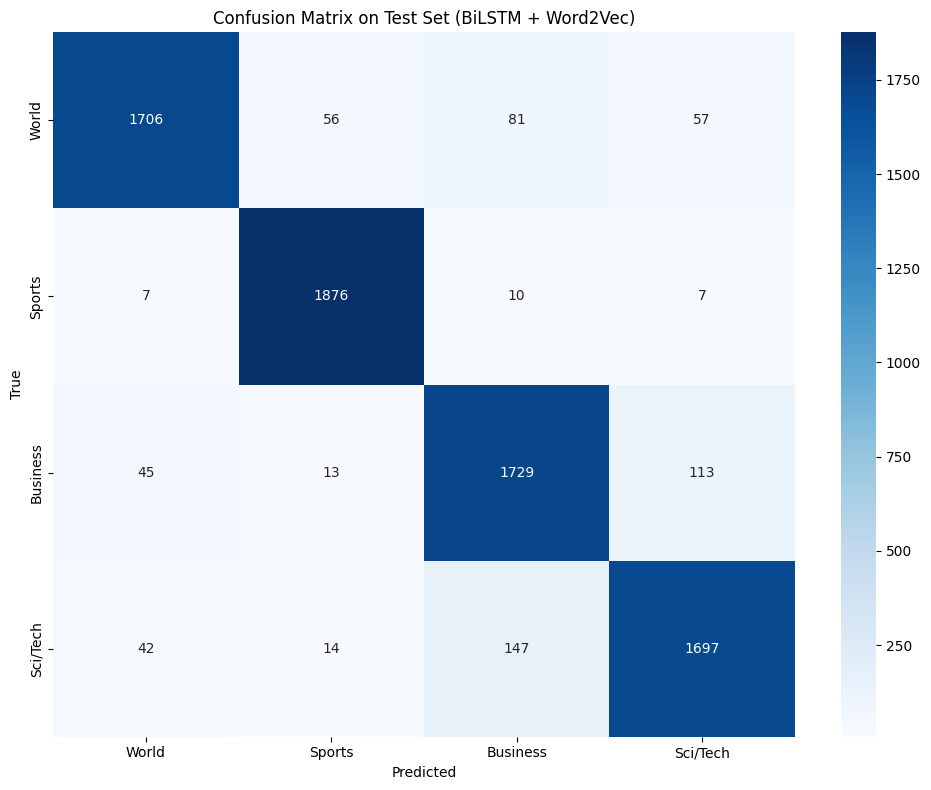

World: Precision=0.948, Recall=0.898, F1=0.922
Sports: Precision=0.958, Recall=0.987, F1=0.972
Business: Precision=0.879, Recall=0.910, F1=0.894
Sci/Tech: Precision=0.906, Recall=0.893, F1=0.899


In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (BiLSTM + Word2Vec)')
plt.tight_layout()
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
